In [668]:
'''
Author: Mikhail Milchenko, mmilchenko@wustl.edu
Copyright (c) 2021, Computational Imaging Research Center, Washington University in St Louis, School of Medicine

Redistribution and use in source and binary forms, for any purpose, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''
import argparse, numpy as np, pydicom, re, skimage.measure, math
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


In [669]:
def expand_3d_contour_raster(contours,dist):
    
    def cont3d2d(cin):
        return [ [cin[i][0],cin[i][1]] for i in range(len(cin)) ]
    
    def cont2d3d(cin,z):
        return [ [cin[i][0],cin[i][1],z] for i in range(len(cin)) ]
    
    def get_rasterized_poly_slice(poly2d, imwid, imht):
        '''
        Create a binary mask from a closed 2D polygon.
        Input: 2d polygon
        output: 2d image
        '''
        img=Image.new('L',(imwid,imht),0)
        ImageDraw.Draw(img).polygon(poly2d,outline=1,fill=1)
        return np.transpose(np.array(img))
    
    def raster2contour(img):
        contours = skimage.measure.find_contours(image, 0.5)
        return cont2d3d(contours[0])
        
    images=[ get_rasterized_poly_slice(c) ]
    
    amin = np.array([ np.array(c).min(0) for c in contours ]).min(0)
    amax = np.array([ np.array(c).max(0) for c in contours ]).max(0)
    
    pwid,pht=math.ceil((amax-amin)[0]),math.ceil((amax-amin)[1])

In [818]:
def rtss_to_contourset(input_rtstruct_dicom:str,verbose=False):    
    '''
    return all contour sets (ROI's) from the input RTSTRUCT file.
    '''
    
    ds_rtss=pydicom.dcmread(input_rtstruct_dicom, stop_before_pixels=False)
    if [0x3006,0x0020] not in ds_rtss: 
        raise ValueError('Cannot find (0x3006,0020) StructureSetROISequence tag in RTSS file')
    structure_set_roi_sequence=ssrs=ds_rtss[(0x3006,0x0020)]._value
    roi_contour_sequence=rcs=ds_rtss[(0x3006,0x0039)]

    n=len(ssrs)
    print ('Found {} structures'.format(n))    
    roi_list=[]
    current_region_code=1
    roi_file_index=0    
    rois=[]
    for ind in range(n):
        ss=ssrs[ind]        
        roi_number=ss[(0x3006,0x0022)].value
        roi_name=re.sub(r'\W+', '', ss[(0x3006,0x0026)].value)
        if verbose: print('ROI number {}, name {}'.format(roi_number,roi_name))
        roi_contour=None
        
        #now find the matching ROI contour.
        for rc in roi_contour_sequence:
            #print ('comparing',rc[0x3006, 0x0084]._value,'and', roi_number)
            if rc[0x3006, 0x0084]._value==roi_number: 
                roi_contour=rc
                break

        if not roi_contour: 
            print('WARNING: no matching roi contour sequence for this ROI')
            continue
            
        if (0x3006,0x0040) in roi_contour:
            contour_sequence=roi_contour[0x3006,0x0040]

        else:
            print('WARNING: no matching contour sequence for this ROI')
            continue
        nContours=len(contour_sequence._value)
        roi=[]
        for k in range(nContours):
            contour=contour_sequence[k]            
            npts=contour.NumberOfContourPoints            
            if verbose: print('Contour {}, number of points: {}'.format(k+1,npts))
            pts=contour.ContourData
            #print(len(pts))
            #print(pts)
            pts_list=[ [float(pts[i]),float(pts[i+1]),float(pts[i+2])] for i in range(0,len(pts),3) ]
            #print (pts_list)
            roi.append(pts_list)            
        rois.append(roi)
        
    return rois


def expand_3d_contour_3dnormals(contours,dist,verbose=False,niterations=-1):
    '''
    Expand by the given distance a 3D object represented by
    a list of closed 2D contours.
    contours is a list of lists of lists (3d points)
    dim1 <-- x , dim2 <-- y, dim3 <-- z (constant), dim4 <-- point index.
    niterations gives the number desired iterations (does not affect the expansion distance)
    niterations=-1 instructs the routine to auto-compute the number of iterations.
    Fewer niterations result in faster and less smooth output.
    '''
    
    def plane_eq(p1,p2):
        return p2[1]-p1[1],p1[0]-p2[0],p1[1]*p2[0]-p1[0]*p2[1]
    
    def eval_plane_eq(pt,a,b,c):
        return a*pt[0]+b*pt[1]+c
    
    def pt_within_segment(p,p1,p2):
        pa,p1a,p2a=np.array(p),np.array(p1),np.array(p2)
        nrm=np.linalg.norm(p2a-p1a)
        return True if np.linalg.norm(p1a-pa)<=nrm and np.linalg.norm(p2a-pa)<=nrm else False
        
    def is_intersection(p1,p2,p3,p4):
        '''
        return None if p1-p2 and p3-p4 do not intersect
        return point of intersection otherwise.
        '''
        a1,b1,c1=plane_eq(p1,p2)
        a2,b2,c2=plane_eq(p3,p4)
        p3e,p4e,p1e,p2e=eval_plane_eq(p3,a1,b1,c1),eval_plane_eq(p4,a1,b1,c1),\
            eval_plane_eq(p1,a2,b2,c2),eval_plane_eq(p2,a2,b2,c2)
        
        s1,s2=p3e*p4e,p1e*p2e            
        nopt=[None,None,None]
        
        if s1<0 and s2<0: #general case
            if abs(a1)>abs(a2):
                if a1==0: print ('a1=0!!!'); return nopt                    
                r=a2/a1
                y0=(c2-r*c1)/(r*b1-b2)
                x0=-(b1*y0+c1)/a1
            else:
                if a2==0: print ('a2=0!!!'); return nopt
                r=a1/a2
                y0=(c1-r*c2)/(r*b2-b1)
                x0=-(b2*y0+c2)/a2
            return [x0,y0,p1[2]]
        elif s1==0 and s2<0: #one of p3,p4 on line segment p1,p2            
            if p3e==0: 
                return p3 if pt_within_segment(p3,p1,p2) else nopt
            else: 
                return p4 if pt_within_segment(p4,p1,p2) else nopt
                            
        elif s2==0 and s1<0: #one of p1,p2 on segment p3,p4            
            if p1e==0: 
                return p1 if pt_within_segment(p1,p3,p4) else nopt
            else: 
                return p2 if pt_within_segment(p2,p3,p4) else nopt
            
        elif s1==0 and s2==0: #p1,p2 and p3,p4 are on the same line            
            if pt_within_segment(p3,p1,p2): return p3 #p3 between p1 and p2
            elif pt_within_segment(p4,p1,p2): return p4 #p4 between p1 and p2
            else: return nopt #no intersection
        else:            
            return nopt
        
    def reindex_contour(contour, shift):
        l,c=len(contour),contour
        return [ c[(i+shift)%l ] for i in range(l) ]
    
    def merge_contours(c1,c2):
        '''
        merge two contours obtained from the same one through reindexing 
        and self intersection removal.
        '''
        tol,out,l=1e-2,[],len(c1)
        d=np.argmin(cdist(c1,c2),1)
        for i in range(l):
            p1,p2=np.array(c1[i]),np.array(c2[d[i]])
            if np.linalg.norm(p1-p2)<tol: out.append(p1.tolist())
        return out
    
    def remove_nfold_self_intersections_robust(contour,n,verbose):
        c,l2=contour,round(len(contour)/2)
        return merge_contours(remove_nfold_self_intersections(c,n,verbose),\
                              remove_nfold_self_intersections(reindex_contour(c,l2),n,verbose))
    
    def remove_nfold_self_intersections(contour,n,verbose):
        '''
        n must be between 1 and l/2
        this function doesn't handle situations where contour starting point is within a loop.
        '''        
        c,l=contour,len(contour)
        if l<1: 
            print ('WARNING: remove_nfold_self_intersections: empty input contour')
            return c
        
        tol=1e-1    
        if abs(l-n-2)/l < 0.5:
            print ('WARNING: remove_nfold_self_intersections: n={} is too large for this contour ({} points)'.format(n,l))
            return c
        
        cout=[]
        found_inter=False
        i=0
        while i < len(c):
            p1,p2,p3,p4=c[i],c[(i+1)%l],c[(i+n+1)%l],c[(i+n+2)%l]
            pint=is_intersection(p1,p2,p3,p4)
            if pint[0] is None: 
                cout.append(p1)
                i+=1
                continue
            if verbose: print ('found self intersection: i={}, n={},pt={}'.format(i,n,pint))
            found_inter=True
            cout.append(p1)
            cout.append(p4)
            i+=3+n
        return cout
    
    def cont3d2d(cin):
        return [ [cin[i][0],cin[i][1]] for i in range(len(cin)) ]
    def cont2d3d(cin,z):
        return [ [cin[i][0],cin[i][1],z] for i in range(len(cin)) ]
    
    def contour_orientation(contour):
        '''
        Return contour orientation: True/False clockwise/counterclockwise
        '''           
        cntr=np.array(contour)
        #print(cntr)
        cntrm=cntr.mean(0)        
    
        cx,cy=cntrm[0],cntrm[1]
        p0=contour[0];
        c=np.array([cx,cy,p0[2]])
        v0=p0-c
        nv0=np.linalg.norm(v0)    
        degacc=0
        for i in range(1,cntr.shape[0]):
            v1=contour[i]-c
            #print(v0,v1)
            d=np.cross(v0,v1)/(np.linalg.norm(v1)*np.linalg.norm(v0))
            degacc+=d
            v0=v1        
        return degacc[2] > 0
        
    #end of contour_orientation code    
     
    def contour_stats(contours):
        '''
        Average edge length and bounding box for output contour set.            
        '''
        out=dict()
        means=[]
        sizes=[]
        mins=[]
        maxs=[]
        for c in contours:
            cc=np.array(c)
            means.append(np.sum(np.array([ np.linalg.norm(cc[i]-cc[i-1]) for i in range(len(c)) ])))            
            sizes.append(len(c))
            cc=np.array(c)
            mins.append(np.min(cc,0))
            maxs.append(np.max(cc,0))
        out['mean_edge']=np.sum(np.array(means))/np.sum(np.array(sizes))
        bbmin,bbmax=np.min(np.array(mins),0),np.max(np.array(maxs),0)
        dbb=bbmax-bbmin
        out['bounding_box_min'],out['bounding_box_max'],out['dims']=bbmin,bbmax,dbb
        return out
        
    def main_iteration(contours,dist,verbose):
        
        def interp_contour3d(c_in,tol):
            z_in=c_in[0][2]
            return np.array(cont2d3d(skimage.measure.approximate_polygon(np.array(cont3d2d(c_in)),tol),z_in))
        
        '''
        Main iteration of contour expansion. Takes in contour list, distance traveled, 
        and verbosity. 
        '''
        
        c,c_out=contours,[]
        imdepth=len(c)
        #tol=dist*0.1
        tol=0.1
        toln=0.0
        
        #all_normals=[]
        for z in range (imdepth):                
            z0=contours[z][0][2]
#            print('z0',z0)
#            print(cont2d3d(skimage.measure.approximate_polygon(np.array(cont3d2d(c[z])),tol),z0))
            c0=interp_contour3d(c[z],tol)
            #print(c0)
            orient_cw=contour_orientation(c0)
            #print('z,orientation',z,orient_cw)
            
            if z>0:
                c_1=interp_contour3d(c[z-1],tol)
                #np.array(c[z-1])
                d_1=np.argmin(cdist(c0,c_1),1)
            else:
                d_1=None

            if z<imdepth-1:
                #c1=np.array(c[z+1])
                c1=interp_contour3d(c[z+1],tol)
                d1=np.argmin(cdist(c0,c1),1)
            else: 
                d1=None
                        
            #print('d_1',d_1)
            #print('d1',d1)
            
            co=[]
            l=len(c0)
            z0=c0[0][2]
            
            for ind in range(len(c0)):
                pt_1,pt0,pt1=c0[ ind-1 ],c0[ind],c0[ (ind+1) % l ]
                vl,vr=pt_1-pt0,pt1-pt0
                normals=[]
                if z>0:
                    vd=c_1[d_1[ind]]-pt0
                    if orient_cw: nl,nr=np.cross(vd,vl),np.cross(vr,vd)
                    else: nl,nr=np.cross(vd,vr),np.cross(vl,vd)                    
                    nnl,nnr=np.linalg.norm(nl),np.linalg.norm(nr)
                    if nnl>toln: normals.append(nl/nnl)
                    if nnr>toln: normals.append(nr/nnr)
                if z<imdepth-1:
                    vu=c1[d1[ind]]-pt0
                    if orient_cw: nl,nr=np.cross(vl,vu),np.cross(vu,vr)
                    else: nl,nr=np.cross(vr,vu),np.cross(vu,vl)
                    nnl,nnr=np.linalg.norm(nl),np.linalg.norm(nr)
                    if nnl>toln: normals.append(nl/nnl)
                    if nnr>toln: normals.append(nr/nnr)
            
                normal=np.median(np.array(normals),0)
                #normal=np.array(normals).sum(0)
                nn=np.linalg.norm(n)
                if nn>toln:
                    normal/=np.linalg.norm(n)                
                else:
                    print('WARNING: contour issue: all normals at point {},{} are zero!',z,ind)

                pt_new=pt0+normal*dist
                pt_new[2]=z0 #project to the plane of the old contour
                co.append([pt_new[0],pt_new[1]])
                                                    
            co1=cont2d3d(co,z0)
            #co1=cont2d3d(skimage.measure.approximate_polygon(np.array(co),tol),z0)            
            if verbose: print('removing self intersections for contour ',z)
            
            #remove up to 3-point self intersections            
            
            co20=remove_nfold_self_intersections_robust(co1,3,verbose);
            co2=remove_nfold_self_intersections_robust(co20,3,verbose)            
            co30=remove_nfold_self_intersections_robust(cont2d3d(co2,z0),2,verbose);
            co3=remove_nfold_self_intersections_robust(cont2d3d(co30,z0),2,verbose);
            co40=remove_nfold_self_intersections_robust(co3,1,verbose)
            co4=remove_nfold_self_intersections_robust(co40,1,verbose)
            
            c_out.append(co4)
            
        return (c_out)
        #end of main_iteration
    
    c_in=contours    
    cst=contour_stats(c_in); 
    if verbose: print(cst)
    mindim=min(cst['dims'][0],cst['dims'][1])
    if dist<0 and -dist>mindim/2:
        print('Shrink distance (d={}) is too large for the object with linear dimensions {}'.format(-dist,cst['dims']))
        return c_in,False
    
    if niterations>0: 
        niter=niterations
    else:
        niter=max(1,math.ceil(abs(dist)/5))
#    else:
#        niter=int(max(1,math.ceil(-dist)/(2*cst['mean_edge'])))

    if verbose: print('Running {} iterations.'.format(niter))        
    iter_dist=dist/niter
        
    for i in range(niter):
        if verbose: print('iteration ',i)
        c_out=main_iteration(c_in,iter_dist,verbose)
        c_in=c_out        
        
    return c_out,True
    #end of expand_3d_contour_mm
    
def show_contour(c,color):
    x=[ pt[0] for pt in c ]
    y=[ pt[1] for pt in c ]
    #print(x)
    #print(y)
    plt.plot(x,y,color=color)
    
def show_normals(c0,c1,color):
    for i in range(len(c0)):
        p0,p1=c0[i],c1[i]
        plt.plot([p0[0],p1[0]],[p0[1],p1[1]],color)
        
    

Found 4 structures


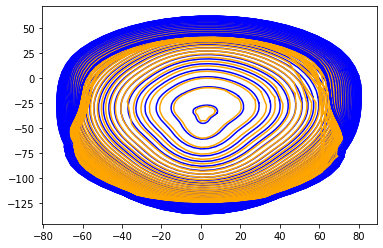

In [841]:
def interp_contour3d(c_in,tol):
    z_in=c_in[0][2]
    return np.array(cont2d3d(skimage.measure.approximate_polygon(np.array(cont3d2d(c_in)),tol),z_in))

#rtss="/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/YashContour/AIM_20200707_124424.dcm"
rtss="/data/TMORPH/I3CR/MW101_MR_tx1_GK/test/RTSTRUCT_study2/2.25.261458899103434642155411796145786023291-1-no-value-for-InstanceNumber-1qq25ix.dcm"
ROIs=rtss_to_contourset(rtss,verbose=False)
contours=ROIs[3][:]

c_out,success=expand_3d_contour_3dnormals(contours,-20,verbose=False,niterations=-1)
n=4

for i in range(len(contours)):
    plt.figure(0)
    #show_contour(contours[i],'blue')
    show_contour(interp_contour3d(contours[i],0.1),'blue')
    show_contour(c_out[i],'orange')
    #show_normals(interp_contour3d(contours[i],0.1),c_out[i],'green')
    
    #show_normals(contours[i],c_out[i],'green')


In [750]:
skimage.measure.approximate_polygon(np.array(cont3d2d(c)),0.1)

array([[-1.5,  0. ],
       [-1. ,  0. ],
       [ 1. ,  1. ],
       [-1. ,  1. ],
       [ 1. ,  0. ],
       [ 1.5,  0. ],
       [ 0. , -1. ]])

In [743]:
c[0]

[-1.5, 0, 0]

In [744]:
c

[[-1.5, 0, 0],
 [-1, 0, 0],
 [1, 1, 0],
 [-1, 1, 0],
 [1, 0, 0],
 [1.5, 0, 0],
 [0, -1, 0]]